# MACHINE LEARNING 
# INFO 284
# SPRING 2021
# STUDENTS: 245 & 213

All the necessary modules that need importing for the program to run:

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


# Inspection of data

## * NOTE *  
### We run this dataset on a downloaded version of the nyc-rolling-sales dataset, for this code to work, the dataset must be downloaded from kaggle and be in the same folder as the code of this program. The name of the dataset should be the same when downloaded as written in the code below.

In [119]:
# load the dataset downloaded from kaggle:

data = pd.read_csv("nyc-rolling-sales.csv")

In [120]:
# inspection of some of the rows and columns:
data

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,...,2,0,2,2400,2575,1998,1,B9,450000,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,...,2,0,2,2498,2377,1998,1,B9,550000,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,...,2,0,2,4000,1496,1925,1,B2,460000,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,...,0,7,7,208033,64117,2001,4,K6,11693337,2016-12-21 00:00:00


First look at the data reveals that "Unnamed: 0" looks like a counter, and "EASE-MENT" looks pretty empty, so we make sure of this then delete if the assumption is true

In [121]:
for col in data:
    print(col, len(data[col].unique()))

Unnamed: 0 26736
BOROUGH 5
NEIGHBORHOOD 254
BUILDING CLASS CATEGORY 47
TAX CLASS AT PRESENT 11
BLOCK 11566
LOT 2627
EASE-MENT 1
BUILDING CLASS AT PRESENT 167
ADDRESS 67563
APARTMENT NUMBER 3989
ZIP CODE 186
RESIDENTIAL UNITS 176
COMMERCIAL UNITS 55
TOTAL UNITS 192
LAND SQUARE FEET 6062
GROSS SQUARE FEET 5691
YEAR BUILT 158
TAX CLASS AT TIME OF SALE 4
BUILDING CLASS AT TIME OF SALE 166
SALE PRICE 10008
SALE DATE 364


In [122]:
del data['Unnamed: 0']
del data['EASE-MENT']

Looking at the data above, we also see that some values of "SALE PRICE" is " -  " in the place of missing values. We could fill this with mean data, however it would not be good for predicting when the target value involves fabricated data, so we delete this.

In [123]:
data['SALE PRICE'] = data['SALE PRICE'].replace(' -  ', np.NaN).astype(np.float)
data = data.dropna(axis=0).reset_index(drop=True)

Next we will check the percentage of values that are "0" in the different columns

In [124]:
data[data==0].count()/len(data)*100

BOROUGH                            0.000000
NEIGHBORHOOD                       0.000000
BUILDING CLASS CATEGORY            0.000000
TAX CLASS AT PRESENT               0.000000
BLOCK                              0.000000
LOT                                0.000000
BUILDING CLASS AT PRESENT          0.000000
ADDRESS                            0.000000
APARTMENT NUMBER                   0.000000
ZIP CODE                           1.111635
RESIDENTIAL UNITS                 29.966994
COMMERCIAL UNITS                  94.194636
TOTAL UNITS                       25.181819
LAND SQUARE FEET                   0.000000
GROSS SQUARE FEET                  0.000000
YEAR BUILT                         7.702859
TAX CLASS AT TIME OF SALE          0.000000
BUILDING CLASS AT TIME OF SALE     0.000000
SALE PRICE                        14.614143
SALE DATE                          0.000000
dtype: float64

There are a lot of 0 values in residential, commercial and total units, which we should clean up by removing entries where 'residential units' and 'commercial units' does not equal 'total units'. We also remove if 'total units' is equal to 0.

In [125]:
# removing too high and too low total units
data = data[(data['TOTAL UNITS'] > 0) & (data['TOTAL UNITS'] < 50)]

# removing where commercial and residential units don't match total units
data = data[data['TOTAL UNITS'] == data['COMMERCIAL UNITS'] + data['RESIDENTIAL UNITS']]

In [126]:
data[data==0].count()/len(data)*100

BOROUGH                            0.000000
NEIGHBORHOOD                       0.000000
BUILDING CLASS CATEGORY            0.000000
TAX CLASS AT PRESENT               0.000000
BLOCK                              0.000000
LOT                                0.000000
BUILDING CLASS AT PRESENT          0.000000
ADDRESS                            0.000000
APARTMENT NUMBER                   0.000000
ZIP CODE                           0.079001
RESIDENTIAL UNITS                  3.709117
COMMERCIAL UNITS                  92.192684
TOTAL UNITS                        0.000000
LAND SQUARE FEET                   0.000000
GROSS SQUARE FEET                  0.000000
YEAR BUILT                         5.711803
TAX CLASS AT TIME OF SALE          0.000000
BUILDING CLASS AT TIME OF SALE     0.000000
SALE PRICE                        16.696951
SALE DATE                          0.000000
dtype: float64

Looking at the unique values of "ADDRESS", we see that around 40 000 values are unique, so for later labeling or one hot encoding, we would get a lot of categories or columns. Therefore we should delete it. "COMMERCIAL UNITS" has over 90% values that are "0", which grants removal.

In [127]:
len(data['ADDRESS'].unique())

40161

In [128]:
del data['ADDRESS']
del data['COMMERCIAL UNITS']

"APARTMENT NUMBER" has a lot of unique values as well, and many of them are missing, which is why we delete it.

In [129]:
del data['APARTMENT NUMBER']

Next we check for duplicates and delete any.

In [130]:
sum(data.duplicated(data.columns))

349

In [131]:
data = data.drop_duplicates(data.columns, keep='last')
sum(data.duplicated(data.columns))

0

Next we will check for rows where "BUILDING CLASS AT TIME OF SALE" and "BUILDING CLASS AT PRESENT does not match, and delete the entries which do not match. We will add a new row called "BUILDING CLASS" which is only for the values that match, then delete the original two columns.

In [132]:
count = 0

for index in data.index: 
    if data["BUILDING CLASS AT TIME OF SALE"][index] != data["BUILDING CLASS AT PRESENT"][index]: 
        count += 1
print(count)

148


In [133]:
data['BUILDING CLASS'] = data['BUILDING CLASS AT PRESENT'] = data['BUILDING CLASS AT TIME OF SALE']

In [134]:
count = 0

data_b = ['BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE']

for c, x in data[data_b].iterrows():
    if x[0] != x[1]:
        count +=1
print(count)

0


In [135]:
del data['BUILDING CLASS AT TIME OF SALE']
del data['BUILDING CLASS AT PRESENT']

Now we look at a combination of the categorical data (or data with other datatypes than numbers)

In [136]:
cat_data=data.select_dtypes(exclude=[np.number])
cat_data.describe()

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,LAND SQUARE FEET,GROSS SQUARE FEET,SALE DATE,BUILDING CLASS
count,50283,50283,50283,50283,50283,50283,50283
unique,250,39,9,4856,4866,360,143
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,-,-,2016-12-22 00:00:00,R4
freq,1617,14396,31055,8639,8779,350,10410


We can see that the most frequent land and gross "SQUARE FEET" are " -  ", this means that we have missed some NaN values that we should remove, these two columns should also be numeric and not be included in this description at all, so we can convert them to float as well. Also, since we allready have made a new column called "BUILDING CLASS" which has more unique values than "BUILDING CLASS CATEGORY", we can delete the last of those, and have more precise, but not overly unique categories for our prediction.

In [137]:
del data["BUILDING CLASS CATEGORY"]

In [138]:
data.shape

(50283, 15)

In [139]:
data['LAND SQUARE FEET'] = data['LAND SQUARE FEET'].replace(' -  ', np.NaN).astype(np.float)
data['GROSS SQUARE FEET'] = data['GROSS SQUARE FEET'].replace(' -  ', np.NaN).astype(np.float)
data = data.dropna(axis=0).reset_index(drop=True)

In [140]:
data.shape

(41501, 15)

As for the rest of the categorical columns, there are managable number of unique values to be one hot encoded or labeled, however as "SALE DATE" has the highest number of unique values, we will have to evaluate if it is a necessary column. Now we take an overview of the current state of our data:

In [141]:
data

,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING CLASS
0,1,ALPHABET CITY,2A,392,6,10009,5,5,1633.0,6440.0,1900,2,6625000.0,2017-07-19 00:00:00,C2
1,1,ALPHABET CITY,2B,402,21,10009,10,10,2272.0,6794.0,1913,2,3936272.0,2016-09-23 00:00:00,C4
2,1,ALPHABET CITY,2A,404,55,10009,6,6,2369.0,4615.0,1900,2,8000000.0,2016-11-17 00:00:00,C2
3,1,ALPHABET CITY,2B,406,32,10009,8,8,1750.0,4226.0,1920,2,3192840.0,2016-09-23 00:00:00,C4
4,1,ALPHABET CITY,2,387,153,10009,24,24,4489.0,18523.0,1920,2,16232000.0,2016-11-07 00:00:00,D9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41496,5,WOODROW,1,7349,34,10309,2,2,2400.0,2575.0,1998,1,450000.0,2016-11-28 00:00:00,B9
41497,5,WOODROW,1,7349,78,10309,2,2,2498.0,2377.0,1998,1,550000.0,2017-04-21 00:00:00,B9
41498,5,WOODROW,1,7351,60,10309,2,2,4000.0,1496.0,1925,1,460000.0,2017-07-05 00:00:00,B2
41499,5,WOODROW,4,7100,28,10309,0,7,208033.0,64117.0,2001,4,11693337.0,2016-12-21 00:00:00,K6


In [142]:
for col in data:
    print(col, len(data[col].unique()))

BOROUGH 5
NEIGHBORHOOD 249
TAX CLASS AT PRESENT 9
BLOCK 10405
LOT 1685
ZIP CODE 177
RESIDENTIAL UNITS 50
TOTAL UNITS 49
LAND SQUARE FEET 4835
GROSS SQUARE FEET 4862
YEAR BUILT 145
TAX CLASS AT TIME OF SALE 3
SALE PRICE 5571
SALE DATE 360
BUILDING CLASS 142


We see that we have two different columns for tax class: "TAX CLASS AT PRESENT" and "TAX CLASS AT TIME OF SALE". While both of these can be interesting to look at, we see that "TAX CLASS AT TIME OF SALE" only has three unique values, which makes it seem as "TAX CLASS AT PRESENT" is more precise with 9 unique values. Therefore we chose to keep "TAX CLASS AT PRESENT".

In [143]:
del data['TAX CLASS AT TIME OF SALE']

In [144]:
data

,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,BUILDING CLASS
0,1,ALPHABET CITY,2A,392,6,10009,5,5,1633.0,6440.0,1900,6625000.0,2017-07-19 00:00:00,C2
1,1,ALPHABET CITY,2B,402,21,10009,10,10,2272.0,6794.0,1913,3936272.0,2016-09-23 00:00:00,C4
2,1,ALPHABET CITY,2A,404,55,10009,6,6,2369.0,4615.0,1900,8000000.0,2016-11-17 00:00:00,C2
3,1,ALPHABET CITY,2B,406,32,10009,8,8,1750.0,4226.0,1920,3192840.0,2016-09-23 00:00:00,C4
4,1,ALPHABET CITY,2,387,153,10009,24,24,4489.0,18523.0,1920,16232000.0,2016-11-07 00:00:00,D9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41496,5,WOODROW,1,7349,34,10309,2,2,2400.0,2575.0,1998,450000.0,2016-11-28 00:00:00,B9
41497,5,WOODROW,1,7349,78,10309,2,2,2498.0,2377.0,1998,550000.0,2017-04-21 00:00:00,B9
41498,5,WOODROW,1,7351,60,10309,2,2,4000.0,1496.0,1925,460000.0,2017-07-05 00:00:00,B2
41499,5,WOODROW,4,7100,28,10309,0,7,208033.0,64117.0,2001,11693337.0,2016-12-21 00:00:00,K6


"SALE DATE" can be an important column, however as it is now it is not useful for our machine learning models, therefore we split it up to year and month.

In [145]:
data['SALE DATE'] = pd.to_datetime(data['SALE DATE'])

data['YEAR'] = data['SALE DATE'].apply(lambda x: x.year)
data['MONTH'] = data['SALE DATE'].apply(lambda x: x.month)
del data['SALE DATE']

In [146]:
data

,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BUILDING CLASS,YEAR,MONTH
0,1,ALPHABET CITY,2A,392,6,10009,5,5,1633.0,6440.0,1900,6625000.0,C2,2017,7
1,1,ALPHABET CITY,2B,402,21,10009,10,10,2272.0,6794.0,1913,3936272.0,C4,2016,9
2,1,ALPHABET CITY,2A,404,55,10009,6,6,2369.0,4615.0,1900,8000000.0,C2,2016,11
3,1,ALPHABET CITY,2B,406,32,10009,8,8,1750.0,4226.0,1920,3192840.0,C4,2016,9
4,1,ALPHABET CITY,2,387,153,10009,24,24,4489.0,18523.0,1920,16232000.0,D9,2016,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41496,5,WOODROW,1,7349,34,10309,2,2,2400.0,2575.0,1998,450000.0,B9,2016,11
41497,5,WOODROW,1,7349,78,10309,2,2,2498.0,2377.0,1998,550000.0,B9,2017,4
41498,5,WOODROW,1,7351,60,10309,2,2,4000.0,1496.0,1925,460000.0,B2,2017,7
41499,5,WOODROW,4,7100,28,10309,0,7,208033.0,64117.0,2001,11693337.0,K6,2016,12


In [147]:
data[data==0].count()/len(data)*100

BOROUGH                  0.000000
NEIGHBORHOOD             0.000000
TAX CLASS AT PRESENT     0.000000
BLOCK                    0.000000
LOT                      0.000000
ZIP CODE                 0.033734
RESIDENTIAL UNITS        4.264957
TOTAL UNITS              0.000000
LAND SQUARE FEET        12.551505
GROSS SQUARE FEET       12.823787
YEAR BUILT               3.395099
SALE PRICE              19.895906
BUILDING CLASS           0.000000
YEAR                     0.000000
MONTH                    0.000000
dtype: float64

"SALE PRICE" has a lot of 0 values, however this is described in the dataset description as people inheriting properties, so these should be excluded. Also, we should look out for any outliers in the column:

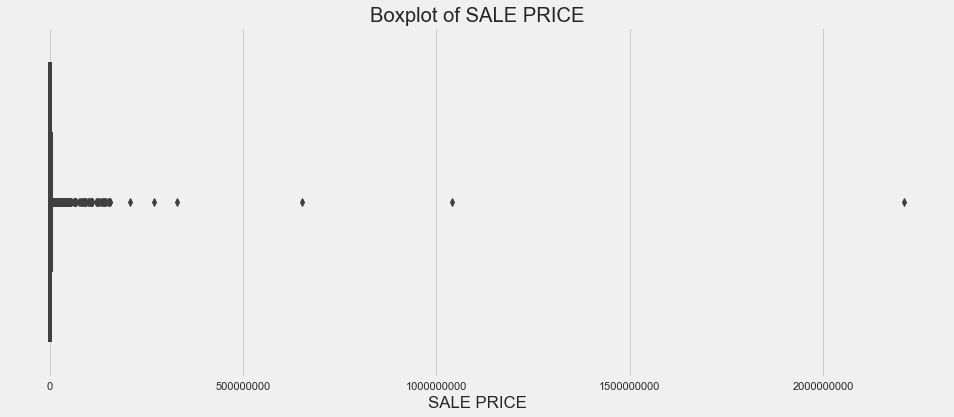

In [148]:
plt.figure(figsize=(15,6))

sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE')
plt.show()

We see that there are a lot of values close to 0, and only a handful that are a lot higher than the others, these are the outliers.

We can plot it in a different graph to view just how high we should restrict our model to exclude any outliers:

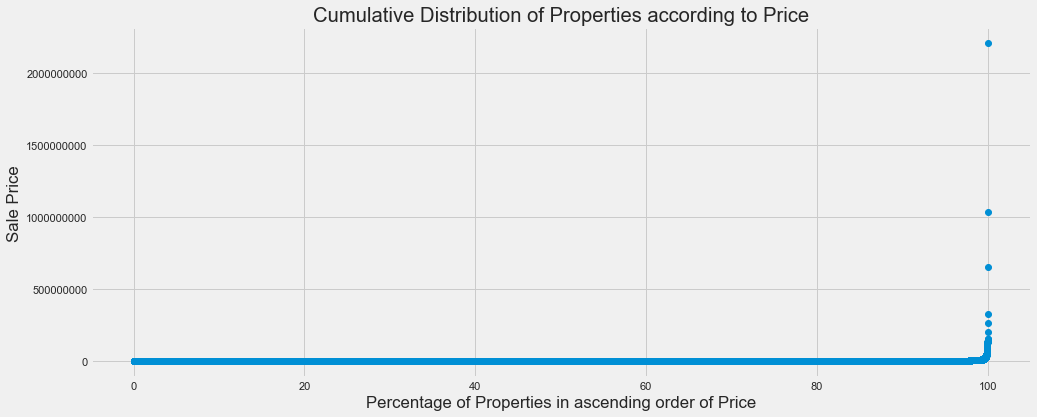

In [149]:

plt.figure(figsize=(15,6))

x = data[['SALE PRICE']].sort_values(by='SALE PRICE').reset_index()
x['PROPERTY PROPORTION'] = 1
x['PROPERTY PROPORTION'] = x['PROPERTY PROPORTION'].cumsum()
x['PROPERTY PROPORTION'] = 100* x['PROPERTY PROPORTION'] / len(x['PROPERTY PROPORTION'])


plt.plot(x['PROPERTY PROPORTION'],x['SALE PRICE'], linestyle='None', marker='o')
plt.title('Cumulative Distribution of Properties according to Price')
plt.xlabel('Percentage of Properties in ascending order of Price')
plt.ylabel('Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

So we remove the outliers by limiting the ammount of sale prices to above 100 000, and below 5 000 000

In [150]:
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]

In [151]:
data.shape

(30776, 15)

Now we can inspect the "SALE PRICE" column and see that tere are not as many outliers as there used to be.

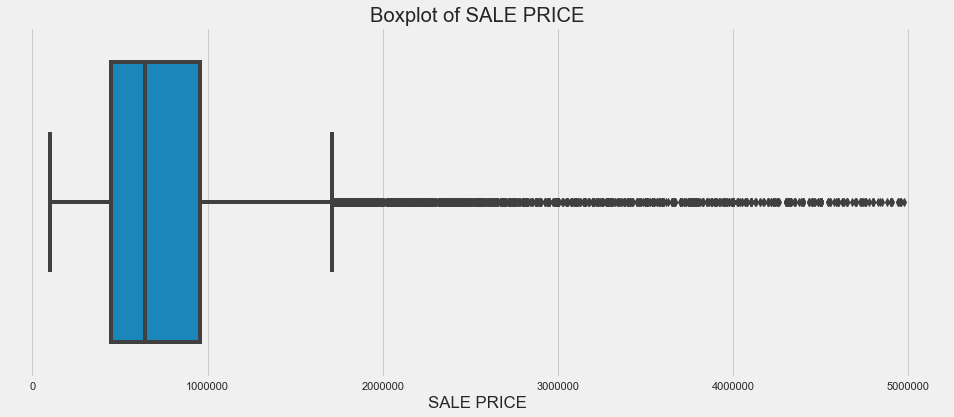

In [152]:
plt.figure(figsize=(15,6))

sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE')
plt.show()

In [153]:
data

,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BUILDING CLASS,YEAR,MONTH
1,1,ALPHABET CITY,2B,402,21,10009,10,10,2272.0,6794.0,1913,3936272.0,C4,2016,9
3,1,ALPHABET CITY,2B,406,32,10009,8,8,1750.0,4226.0,1920,3192840.0,C4,2016,9
7,1,ALPHABET CITY,2A,391,19,10009,3,4,1520.0,3360.0,1910,3300000.0,S3,2016,11
9,1,ALPHABET CITY,2A,394,5,10009,5,6,1779.0,3713.0,1910,4750000.0,S5,2017,4
10,1,ALPHABET CITY,4,390,34,10009,0,1,1218.0,3586.0,1899,3700000.0,K4,2016,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41494,5,WOODROW,1,7316,93,10309,2,2,3325.0,1300.0,1995,509000.0,B2,2016,10
41495,5,WOODROW,1,7317,126,10309,2,2,11088.0,2160.0,1994,648000.0,B2,2016,12
41496,5,WOODROW,1,7349,34,10309,2,2,2400.0,2575.0,1998,450000.0,B9,2016,11
41497,5,WOODROW,1,7349,78,10309,2,2,2498.0,2377.0,1998,550000.0,B9,2017,4


In [154]:
data[data==0].count()/len(data)*100

BOROUGH                  0.000000
NEIGHBORHOOD             0.000000
TAX CLASS AT PRESENT     0.000000
BLOCK                    0.000000
LOT                      0.000000
ZIP CODE                 0.029244
RESIDENTIAL UNITS        2.540941
TOTAL UNITS              0.000000
LAND SQUARE FEET        13.231089
GROSS SQUARE FEET       13.380556
YEAR BUILT               3.249285
SALE PRICE               0.000000
BUILDING CLASS           0.000000
YEAR                     0.000000
MONTH                    0.000000
dtype: float64

We still have some columns with a substantial ammount of "0" values, so instead of deleting these and lose a lot of valuable sale price data, we fill the 0 values with the mean.

In [155]:
for column in ['ZIP CODE', 'RESIDENTIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']:
    data[column] = data[column].replace(0, np.NaN).astype(np.float)
    data[column] = data[column].fillna(data[column].mean())

Now we can see that there are no values that are 0 in any of the columns.

In [156]:
data[data==0].count()/len(data)*100

BOROUGH                 0.0
NEIGHBORHOOD            0.0
TAX CLASS AT PRESENT    0.0
BLOCK                   0.0
LOT                     0.0
ZIP CODE                0.0
RESIDENTIAL UNITS       0.0
TOTAL UNITS             0.0
LAND SQUARE FEET        0.0
GROSS SQUARE FEET       0.0
YEAR BUILT              0.0
SALE PRICE              0.0
BUILDING CLASS          0.0
YEAR                    0.0
MONTH                   0.0
dtype: float64

Next we should convert the float values back to int:

In [157]:
data.dtypes

BOROUGH                   int64
NEIGHBORHOOD             object
TAX CLASS AT PRESENT     object
BLOCK                     int64
LOT                       int64
ZIP CODE                float64
RESIDENTIAL UNITS       float64
TOTAL UNITS               int64
LAND SQUARE FEET        float64
GROSS SQUARE FEET       float64
YEAR BUILT              float64
SALE PRICE              float64
BUILDING CLASS           object
YEAR                      int64
MONTH                     int64
dtype: object

In [158]:
for col in ['ZIP CODE', 'RESIDENTIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE']:
    data[col] = data[col].astype(np.int)

In [159]:
data.dtypes

BOROUGH                  int64
NEIGHBORHOOD            object
TAX CLASS AT PRESENT    object
BLOCK                    int64
LOT                      int64
ZIP CODE                 int64
RESIDENTIAL UNITS        int64
TOTAL UNITS              int64
LAND SQUARE FEET         int64
GROSS SQUARE FEET        int64
YEAR BUILT               int64
SALE PRICE               int64
BUILDING CLASS          object
YEAR                     int64
MONTH                    int64
dtype: object

In [160]:
data

,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BUILDING CLASS,YEAR,MONTH
1,1,ALPHABET CITY,2B,402,21,10009,10,10,2272,6794,1913,3936272,C4,2016,9
3,1,ALPHABET CITY,2B,406,32,10009,8,8,1750,4226,1920,3192840,C4,2016,9
7,1,ALPHABET CITY,2A,391,19,10009,3,4,1520,3360,1910,3300000,S3,2016,11
9,1,ALPHABET CITY,2A,394,5,10009,5,6,1779,3713,1910,4750000,S5,2017,4
10,1,ALPHABET CITY,4,390,34,10009,1,1,1218,3586,1899,3700000,K4,2016,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41494,5,WOODROW,1,7316,93,10309,2,2,3325,1300,1995,509000,B2,2016,10
41495,5,WOODROW,1,7317,126,10309,2,2,11088,2160,1994,648000,B2,2016,12
41496,5,WOODROW,1,7349,34,10309,2,2,2400,2575,1998,450000,B9,2016,11
41497,5,WOODROW,1,7349,78,10309,2,2,2498,2377,1998,550000,B9,2017,4


Next we will look at the description of first: only the categorical data, and second: the rest of the data.

In [161]:
cat_data=data.select_dtypes(exclude=[np.number])
cat_data.describe()

,NEIGHBORHOOD,TAX CLASS AT PRESENT,BUILDING CLASS
count,30776,30776,30776
unique,243,9,109
top,BEDFORD STUYVESANT,1,A1
freq,764,24130,4637


In [162]:
data.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,YEAR,MONTH
count,30776.000000,30776.000000,30776.000000,30776.000000,30776.000000,30776.000000,30776.000000,30776.000000,30776.000000,3.077600e+04,30776.000000,30776.00000
mean,3.515564,5350.809819,226.652846,11037.009195,1.763452,1.830322,3234.756174,2330.365285,1946.374253,8.309739e+05,2016.650799,6.56622
std,0.925749,3728.482649,482.795400,437.908600,1.796557,1.904392,9028.351063,5041.087009,34.385760,6.603761e+05,0.476725,3.46899
min,1.000000,1.000000,1.000000,10001.000000,1.000000,1.000000,200.000000,120.000000,1800.000000,1.007000e+05,2016.000000,1.00000
25%,3.000000,2363.000000,22.000000,10468.000000,1.000000,1.000000,2000.000000,1406.000000,1920.000000,4.499000e+05,2016.000000,4.00000
50%,3.000000,4755.500000,46.000000,11221.000000,1.000000,1.000000,2652.000000,2000.000000,1935.000000,6.450000e+05,2017.000000,6.00000
75%,4.000000,7585.500000,96.000000,11367.000000,2.000000,2.000000,3405.000000,2364.000000,1965.000000,9.550000e+05,2017.000000,10.00000
max,5.000000,16319.000000,5361.000000,11694.000000,48.000000,48.000000,970000.000000,566858.000000,2017.000000,4.975000e+06,2017.000000,12.00000


Finally before we start encoding, we get an overview of all columns unique values, as well as their data types.

In [163]:
for col in data:
    print(col, len(data[col].unique()), data[col].dtypes)

BOROUGH 5 int64
NEIGHBORHOOD 243 object
TAX CLASS AT PRESENT 9 object
BLOCK 9768 int64
LOT 1498 int64
ZIP CODE 169 int64
RESIDENTIAL UNITS 38 int64
TOTAL UNITS 39 int64
LAND SQUARE FEET 4082 int64
GROSS SQUARE FEET 3601 int64
YEAR BUILT 136 int64
SALE PRICE 4827 int64
BUILDING CLASS 109 object
YEAR 2 int64
MONTH 12 int64


# LABEL ENCODING

Since we have some categorical data, and machine learning models can only work with numerical values, we will have to encode the categorical values. There are a couple of different approaches to how one should encode categorical data, so for our assignment, we decided to first label encode it, then one-hot encode it afterwards, so we can compare and see what encoding works better with the different machine learning models. First up is label encoding which simply gives the categorical data a numeric value in the categorical value's place. So if we for example have a column "Street Name" with 50 unique values, each unique value would be assigned a numeric value in the range of unique values.

In [164]:
# first we create a copy of the original data to be labeled
data_label = data.copy()

In [165]:
le = LabelEncoder()

In [166]:
data_label

,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BUILDING CLASS,YEAR,MONTH
1,1,ALPHABET CITY,2B,402,21,10009,10,10,2272,6794,1913,3936272,C4,2016,9
3,1,ALPHABET CITY,2B,406,32,10009,8,8,1750,4226,1920,3192840,C4,2016,9
7,1,ALPHABET CITY,2A,391,19,10009,3,4,1520,3360,1910,3300000,S3,2016,11
9,1,ALPHABET CITY,2A,394,5,10009,5,6,1779,3713,1910,4750000,S5,2017,4
10,1,ALPHABET CITY,4,390,34,10009,1,1,1218,3586,1899,3700000,K4,2016,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41494,5,WOODROW,1,7316,93,10309,2,2,3325,1300,1995,509000,B2,2016,10
41495,5,WOODROW,1,7317,126,10309,2,2,11088,2160,1994,648000,B2,2016,12
41496,5,WOODROW,1,7349,34,10309,2,2,2400,2575,1998,450000,B9,2016,11
41497,5,WOODROW,1,7349,78,10309,2,2,2498,2377,1998,550000,B9,2017,4


Now we choose the different columns for labeling, some of the values are numerical and have a lot of unique values, hence there is not really any point of labeling them. The categorical data we chose to label can be seen in the following code, in the list variable named "data_for_labeling". These values are categorical, and do not have an excessive ammount of unique values. 

In [167]:
data_for_labeling = ['NEIGHBORHOOD', 'TAX CLASS AT PRESENT', 'BUILDING CLASS', 'ZIP CODE', 'YEAR BUILT', 'YEAR', 'MONTH']

for i in data_for_labeling:
    data_label[i] = le.fit_transform(data_label[i])

data_label

,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BUILDING CLASS,YEAR,MONTH
1,1,1,6,402,21,4,10,10,2272,6794,31,3936272,17,0,8
3,1,1,6,406,32,4,8,8,1750,4226,38,3192840,17,0,8
7,1,1,5,391,19,4,3,4,1520,3360,28,3300000,96,0,10
9,1,1,5,394,5,4,5,6,1779,3713,28,4750000,98,1,3
10,1,1,8,390,34,4,1,1,1218,3586,17,3700000,59,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41494,5,240,0,7316,93,41,2,2,3325,1300,113,509000,10,0,9
41495,5,240,0,7317,126,41,2,2,11088,2160,112,648000,10,0,11
41496,5,240,0,7349,34,41,2,2,2400,2575,116,450000,12,0,10
41497,5,240,0,7349,78,41,2,2,2498,2377,116,550000,12,1,3


Now we can see that for example the column "NEIGHBORHOOD" has numerical values instead of the string values which were the names of the different neighborhoods. An interesting observation, since "YEAR" only has two unique values 2016 and 2017, it only has 0 and 1 after labeling, which resembles one-hot encoding.

In [168]:
data_label['YEAR'].unique()

array([0, 1])

In [169]:
# checking unique values again before one-hot encoding
for col in data_label:
    print(col, len(data_label[col].unique()))

BOROUGH 5
NEIGHBORHOOD 243
TAX CLASS AT PRESENT 9
BLOCK 9768
LOT 1498
ZIP CODE 169
RESIDENTIAL UNITS 38
TOTAL UNITS 39
LAND SQUARE FEET 4082
GROSS SQUARE FEET 3601
YEAR BUILT 136
SALE PRICE 4827
BUILDING CLASS 109
YEAR 2
MONTH 12


# ONE-HOT ENCODING

Labeling data is a great way of making categorical data into numerical values so it will be able to run on the different machine learning models. However, the models can sometimes differentiate between lower and higher values, and interpret this as higher values = more important, which is not always the case. Therefore we also wanted to try out these models with one-hot encoded data.

One-hot encoding is a different approach than labeling as instead of giving categorical data a number in the allready excisting column, it creates a new column for each unique value, assigning it either a 0, or a 1 for whether or not the spesific row has the category specified in the different columns. 

In [170]:
# we start by creating a copy of data_label, then to one-hot encode it.

data_one = data_label.copy()

In [171]:
data_one

,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BUILDING CLASS,YEAR,MONTH
1,1,1,6,402,21,4,10,10,2272,6794,31,3936272,17,0,8
3,1,1,6,406,32,4,8,8,1750,4226,38,3192840,17,0,8
7,1,1,5,391,19,4,3,4,1520,3360,28,3300000,96,0,10
9,1,1,5,394,5,4,5,6,1779,3713,28,4750000,98,1,3
10,1,1,8,390,34,4,1,1,1218,3586,17,3700000,59,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41494,5,240,0,7316,93,41,2,2,3325,1300,113,509000,10,0,9
41495,5,240,0,7317,126,41,2,2,11088,2160,112,648000,10,0,11
41496,5,240,0,7349,34,41,2,2,2400,2575,116,450000,12,0,10
41497,5,240,0,7349,78,41,2,2,2498,2377,116,550000,12,1,3


Since one-hot encoding involves the creation of many new columns, we decided to only one-hot encode a handful of the columns, to reduce the computational cost of running the different machine learning models. The columns we chose can be seen in the list variable in the code below named "data_for_one". 

In [172]:
data_for_one = ['NEIGHBORHOOD', 'TAX CLASS AT PRESENT', 'BUILDING CLASS']
data_cat = data_one[data_for_one]

In [173]:
# data_cat_dum is only the one hot encoded columns, not the entire one-hot encoded data.
data_cat_dum = pd.get_dummies(data_cat, columns = data_for_one, drop_first=True)
data_cat_dum

,NEIGHBORHOOD_1,NEIGHBORHOOD_2,NEIGHBORHOOD_3,NEIGHBORHOOD_4,NEIGHBORHOOD_5,NEIGHBORHOOD_6,NEIGHBORHOOD_7,NEIGHBORHOOD_8,NEIGHBORHOOD_9,NEIGHBORHOOD_10,...,BUILDING CLASS_99,BUILDING CLASS_100,BUILDING CLASS_101,BUILDING CLASS_102,BUILDING CLASS_103,BUILDING CLASS_104,BUILDING CLASS_105,BUILDING CLASS_106,BUILDING CLASS_107,BUILDING CLASS_108
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
# concatinate the one-hot encoded columns, with the rest of the data:

data_one = pd.concat([data_one, data_cat_dum], axis=1)

In [175]:
# data_one is the entire one-hot encoded data.
data_one

,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,...,BUILDING CLASS_99,BUILDING CLASS_100,BUILDING CLASS_101,BUILDING CLASS_102,BUILDING CLASS_103,BUILDING CLASS_104,BUILDING CLASS_105,BUILDING CLASS_106,BUILDING CLASS_107,BUILDING CLASS_108
1,1,1,6,402,21,4,10,10,2272,6794,...,0,0,0,0,0,0,0,0,0,0
3,1,1,6,406,32,4,8,8,1750,4226,...,0,0,0,0,0,0,0,0,0,0
7,1,1,5,391,19,4,3,4,1520,3360,...,0,0,0,0,0,0,0,0,0,0
9,1,1,5,394,5,4,5,6,1779,3713,...,0,0,0,0,0,0,0,0,0,0
10,1,1,8,390,34,4,1,1,1218,3586,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41494,5,240,0,7316,93,41,2,2,3325,1300,...,0,0,0,0,0,0,0,0,0,0
41495,5,240,0,7317,126,41,2,2,11088,2160,...,0,0,0,0,0,0,0,0,0,0
41496,5,240,0,7349,34,41,2,2,2400,2575,...,0,0,0,0,0,0,0,0,0,0
41497,5,240,0,7349,78,41,2,2,2498,2377,...,0,0,0,0,0,0,0,0,0,0


In [176]:
# remove the labeled columns which have been one-hot encoded, to avoid duplicates:

for i in data_for_one:
    del data_one[i]
data_one

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,...,BUILDING CLASS_99,BUILDING CLASS_100,BUILDING CLASS_101,BUILDING CLASS_102,BUILDING CLASS_103,BUILDING CLASS_104,BUILDING CLASS_105,BUILDING CLASS_106,BUILDING CLASS_107,BUILDING CLASS_108
1,1,402,21,4,10,10,2272,6794,31,3936272,...,0,0,0,0,0,0,0,0,0,0
3,1,406,32,4,8,8,1750,4226,38,3192840,...,0,0,0,0,0,0,0,0,0,0
7,1,391,19,4,3,4,1520,3360,28,3300000,...,0,0,0,0,0,0,0,0,0,0
9,1,394,5,4,5,6,1779,3713,28,4750000,...,0,0,0,0,0,0,0,0,0,0
10,1,390,34,4,1,1,1218,3586,17,3700000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41494,5,7316,93,41,2,2,3325,1300,113,509000,...,0,0,0,0,0,0,0,0,0,0
41495,5,7317,126,41,2,2,11088,2160,112,648000,...,0,0,0,0,0,0,0,0,0,0
41496,5,7349,34,41,2,2,2400,2575,116,450000,...,0,0,0,0,0,0,0,0,0,0
41497,5,7349,78,41,2,2,2498,2377,116,550000,...,0,0,0,0,0,0,0,0,0,0


Now, instead of having 15 columns, as in the labeled data, we have 370 columns, which is a lot more, and will require a lot more computational power to execute, however it will reduce the model's assumption that higher values are more important.

# Testing out both labeled data, and one hot encoded data on the different machine learning models

### We will offer an overview of the results from different models later in the assignment, where we will discuss and compare in detail

first lets create X and y for both label and one hot encoded data:

In [218]:
y_l = data_label['SALE PRICE'].copy()
X_l = data_label.drop('SALE PRICE', axis=1).copy()

y_o = data_one['SALE PRICE'].copy()
X_o = data_one.drop('SALE PRICE', axis=1).copy()

In [219]:
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.25, random_state=42)

X_o_train, X_o_test, y_o_train, y_o_test = train_test_split(X_o, y_o, test_size=0.25, random_state=42)

# LINEAR REGRESSION

Linear regression is the simplest of the linear models, and is a great way to start testing out the data on a model. This particular model offers no parameters which makes it impossible to control model complexity.

In [221]:
# Linear regression on the labeled data:
lr_l = LinearRegression().fit(X_l_train, y_l_train)
print("Labeled data \n")
print("Training set score: {:.2f}".format(lr_l.score(X_l_train, y_l_train)))
print("Test test score: {:.2f}".format(lr_l.score(X_l_test, y_l_test)))
print("\n")
print("------------------------------")
print("\n")

# Linear regression on the one-hot encoded data:
lr_o = LinearRegression().fit(X_o_train, y_o_train)
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(lr_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(lr_o.score(X_o_test, y_o_test)))


Labeled data 

Training set score: 0.29
Test test score: 0.29


------------------------------


One-hot encoded data 

Training set score: 0.61
Test set score: 0.57


# RIDGE REGRESSION

Ridge regression is another linear model, which in some ways are similar to Linear regression. However, this linear model uses a form of regularization called L2 regularization. L2 regularization restricts the model to avoid overfitting.

In [180]:
ridge_l = Ridge().fit(X_l_train, y_l_train)
print("Labeled data \n")
print("Training set score: {:.2f}".format(ridge_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(ridge_l.score(X_l_test, y_l_test)))
print("\n")
print("------------------------------")
print("\n")
ridge_o = Ridge().fit(X_o_train, y_o_train)
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(ridge_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(ridge_o.score(X_o_test, y_o_test)))

Labeled data 

Training set score: 0.29
Test set score: 0.29


------------------------------


One-hot encoded data 

Training set score: 0.60
Test set score: 0.57


Ridge regression has a parameter called "alpha" which by default is 1.0 by default. This parameter controls the balance of the model between simplicity and performance on the training set. Higher alpha forces coefficients to move more towars zero, which might reduce the training set score, but at the same time help with generalization.

Our next step is to figure out the optimal alpha value for ridge regression, using Grid Search CV, we can iterate through and search for the best alpha value and print it out.

In [181]:
#find best alpha value for ridge regression on labeled data:
ridge = Ridge()
parameters={'alpha':[-10, -5, -0.25, 0, 0.25, 5, 10, 50, 100, 7000, 7500, 8000]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_l, y_l)
print('Best alpha for label ridge regression:', ridge_regressor.best_params_)

#find best alpha value for ridge regression on one hot encoded data:
ridge = Ridge()
parameters={'alpha':[-10, -5, -0.25, 0, 0.25, 5, 10, 50, 100, 7000, 7500, 8000]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_o, y_o)
print('Best alpha for one hot ridge regression:', ridge_regressor.best_params_)

best alpha for label ridge regression: {'alpha': 7500}
best alpha for one hot ridge regression: {'alpha': 7000}


Then, we run the same code again, with the specified alpha value, and check if the scores have improved, and if potential over or underfitting has decreased.

In [182]:
#testing the new alpha values for both labeled and one hot encoded data:

ridge_l = Ridge(alpha = 7500).fit(X_l_train, y_l_train)
print("Labeled data \n")
print("Training set score: {:.2f}".format(ridge_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(ridge_l.score(X_l_test, y_l_test)))
print("\n")
print("------------------------------")
print("\n")
ridge_o = Ridge(alpha = 10).fit(X_o_train, y_o_train)
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(ridge_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(ridge_o.score(X_o_test, y_o_test)))

Labeled data 

Training set score: 0.29
Test set score: 0.29


------------------------------


One-hot encoded data 

Training set score: 0.58
Test set score: 0.56


Interesting observation, grid search reveals that 7000 is the ideal alpha value for the one hot encoded dataset. However, with alpha=10 both training test and test set get a significantly improved score, while still not being overfitted. We figured this out by manually hardcoding and testing different alpha values in the code above.

# LASSO REGRESSION

Lasso regression is the third linear model we run on our datasets, and is an alternative to ridge regression using L1 regularization instead of L2. With L1 regularization some coefficients are set to 0, and therefore are ignored by the machine learning model.

In [183]:
lasso_l = Lasso().fit(X_l_train, y_l_train)
print("Labeled data \n")
print("Training set score: {:.2f}".format(lasso_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(lasso_l.score(X_l_test, y_l_test)))
print("Number of features used:", np.sum(lasso_l.coef_ != 0))
print("\n")
print("------------------------------")
print("\n")
lasso_o = Lasso().fit(X_o_train, y_o_train)
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(lasso_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(lasso_o.score(X_o_test, y_o_test)))
print("Number of features used:", np.sum(lasso_o.coef_ != 0))

Labeled data 

Training set score: 0.29
Test set score: 0.29
Number of features used: 14


------------------------------


One-hot encoded data 

Training set score: 0.61
Test set score: 0.57
Number of features used: 359


This linear model also has the alpha parameter, and therefore we want to find the optimal alpha value, so we perform a grid search again.

In [184]:
#find best alpha value for lasso regression on labeled data:
lasso = Lasso()
parameters={'alpha':[-10, -5, -0.25, 0, 0.25, 5, 10, 50, 100, 7000, 7500, 8000]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)
lasso_regressor.fit(X_l, y_l)
print('best alpha for label lasso regression:', lasso_regressor.best_params_)

#find best alpha value for lasso regression on one hot encoded data:
lasso = Lasso()
parameters={'alpha':[-10, -5, -0.25, 0, 0.25, 5, 10, 50, 100, 7000, 7500, 8000]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=3,n_jobs=-1)
lasso_regressor.fit(X_o, y_o)
print('best alpha for one hot lasso regression:', lasso_regressor.best_params_)

best alpha for label lasso regression: {'alpha': 7500}
best alpha for one hot lasso regression: {'alpha': 7000}


Now we run the code again with the new alpha values, and check for differences.

In [185]:
lasso_l = Lasso(alpha = 7500).fit(X_l_train, y_l_train)
print("Labeled data \n")
print("Training set score: {:.2f}".format(lasso_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(lasso_l.score(X_l_test, y_l_test)))
print("Number of features used:", np.sum(lasso_l.coef_ != 0))
print("\n")
print("------------------------------")
print("\n")
lasso_o = Lasso(alpha = 200).fit(X_o_train, y_o_train)
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(lasso_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(lasso_o.score(X_o_test, y_o_test)))
print("Number of features used:", np.sum(lasso_o.coef_ != 0))

Labeled data 

Training set score: 0.29
Test set score: 0.29
Number of features used: 13


------------------------------


One-hot encoded data 

Training set score: 0.57
Test set score: 0.55
Number of features used: 222


It is the same for lasso as for ridge regression, where the grid search chooses the best alpha as 7000, however with some manual testing of different alpha values, alpha = 200 gives a better overall score while not being over or underfitted.

# RANDOM FORREST REGRESSOR

The random forrest regressor is an ensamble of decision trees, which involves several different machine learning models to create one more powerful one. As decision trees are prone to overfitting training data, we would rather use random forrest regressor, where we can tune the parameters to try and avoid such overfitting.

In [187]:
print("Labeled data \n")
print("Training set score: {:.2f}".format(regressor_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(regressor_l.score(X_l_test, y_l_test)))
print("\n")
print("------------------------------")
print("\n")
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(regressor_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(regressor_o.score(X_o_test, y_o_test)))

Labeled data 

Training set score: 0.92
Test set score: 0.61


------------------------------


One-hot encoded data 

Training set score: 0.92
Test set score: 0.61


Without any parameter tuning, the random forrest regressor overfits quite substantually. However with grid search to find the best min_samples_leaf which is the minimum number of samples required to be at a leaf node, we can see that the overfitting is reduced greatly.

In [211]:
#find best min_samples_leaf value for random forest regression on labeled data:
regressor_l = RandomForestRegressor()
parameters={'min_samples_leaf':[25, 50, 75, 100]}
regressor_l_regressor=GridSearchCV(regressor_l,parameters,scoring='neg_mean_squared_error',cv=5)
regressor_l_regressor.fit(X_l, y_l)
print('best min_samples_leaf parameter for label random forrest regression:', regressor_l_regressor.best_params_)

#find best min_samples_leaf value for random forest regression on one hot encoded data:
regressor_o = RandomForestRegressor()
parameters={'min_samples_leaf':[25, 50, 75, 100]}
regressor_o_regressor=GridSearchCV(regressor_o,parameters,scoring='neg_mean_squared_error',cv=3)
regressor_o_regressor.fit(X_o, y_o)
print('best min_samples_leaf for one-hot encoded random forrest regression:', regressor_o_regressor.best_params_)

best max_depth parameter for label random forrest regression: {'min_samples_leaf': 25}
best alpha for one hot encoded random forrest regression: {'min_samples_leaf': 50}


In [212]:
regressor_l = RandomForestRegressor(min_samples_leaf=25, max_depth = 1000, n_estimators=100, random_state=42)
regressor_l.fit(X_l_train, y_l_train)

regressor_o = RandomForestRegressor(min_samples_leaf=50, max_depth = 1000, n_estimators=100, random_state=42)
regressor_o.fit(X_o_train, y_o_train)

print("Labeled data \n")
print("Training set score: {:.2f}".format(regressor_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(regressor_l.score(X_l_test, y_l_test)))
print("\n")
print("------------------------------")
print("\n")
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(regressor_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(regressor_o.score(X_o_test, y_o_test)))

Labeled data 

Training set score: 0.68
Test set score: 0.63


------------------------------


One-hot encoded data 

Training set score: 0.63
Test set score: 0.60


# K NEIGHBORS REGRESSOR

K Neighbors regressor works similar to the K nearest neighbor, however the regression version aims at predicting a value of an output by using a local average, instead of predicting what class the output variable belongs in by computing the local probability. This model is known to work slowly on large datasets, and perform bad with sparse data, so it will be interesting to see how it performs on one-hot encoded data. 

In [190]:
neigh_l = KNeighborsRegressor(n_neighbors=5)
neigh_l.fit(X_l_train, y_l_train)

neigh_o = KNeighborsRegressor(n_neighbors=5)
neigh_o.fit(X_o_train, y_o_train)
print("Labeled data \n")
print("Training set score: {:.2f}".format(neigh_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(neigh_l.score(X_l_test, y_l_test)))
print("\n")
print("------------------------------")
print("\n")
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(neigh_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(neigh_o.score(X_o_test, y_o_test)))

Labeled data 

Training set score: 0.68
Test set score: 0.51


------------------------------


One-hot encoded data 

Training set score: 0.67
Test set score: 0.50


For this model, we use grid search to find the best parameter for n_neighbors.

In [191]:
#find best n_neighbors value for K neighbors regression on labeled data:
kneigh_l = KNeighborsRegressor()
parameters={'n_neighbors':[250, 300, 350]}
kneigh_l=GridSearchCV(kneigh_l,parameters,scoring='neg_mean_squared_error',cv=5)
kneigh_l.fit(X_l, y_l)
print('best n_neighbors for label K neighbors regression:', kneigh_l.best_params_)

#find best n_neighbors value for K neighbors regression on one hot data:
kneigh_o = KNeighborsRegressor()
parameters={'n_neighbors':[250, 300, 350]}
kneigh_o=GridSearchCV(kneigh_o,parameters,scoring='neg_mean_squared_error',cv=5)
kneigh_o.fit(X_l, y_l)
print('best n_neighbors for one-hot K neighbors regression:', kneigh_o.best_params_)

best k_neighbors for label K neighbors regression: {'n_neighbors': 300}
best k_neighbors for label K neighbors regression: {'n_neighbors': 300}


In [192]:
neigh_l = KNeighborsRegressor(n_neighbors=300)
neigh_l.fit(X_l_train, y_l_train)

neigh_o = KNeighborsRegressor(n_neighbors=300)
neigh_o.fit(X_o_train, y_o_train)
print("Labeled data \n")
print("Training set score: {:.2f}".format(neigh_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(neigh_l.score(X_l_test, y_l_test)))
print("\n")
print("------------------------------")
print("\n")
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(neigh_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(neigh_o.score(X_o_test, y_o_test)))

Labeled data 

Training set score: 0.45
Test set score: 0.44


------------------------------


One-hot encoded data 

Training set score: 0.44
Test set score: 0.44


# NEURAL NETWORK

The neural network we will be using for our assignment is the MLP Regressor, also known as multi-layer perceptron regressor. The MLP Regressor is a feedforward artificial neural network, that uses a supervised learning technique called backpropagation for training. 

We tried using a grid search, to identify the ideal parameters for the MLP regressor, but this took too long to run, so instead we experimented with manually changing the parameters in the code below.

In [223]:
nn_l = MLPRegressor(hidden_layer_sizes = [12,6], activation = 'relu', alpha = 1, max_iter = 10000, solver = 'adam')
nn_l.fit(X_l_train,y_l_train)
print("Labeled data \n")
print("Training set score: {:.2f}".format(nn_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(nn_l.score(X_l_test, y_l_test)))

print("\n")
print("------------------------------")
print("\n")

nn_o = MLPRegressor(hidden_layer_sizes = [12,6], activation = 'relu', alpha = 1, max_iter = 10000, solver = 'adam')
nn_o.fit(X_o_train,y_o_train)
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(nn_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(nn_o.score(X_o_test, y_o_test)))


Labeled data 

Training set score: 0.37
Test set score: 0.38


------------------------------


One-hot encoded data 

Training set score: 0.53
Test set score: 0.50


## Overview of all the scores for the different machine learning models:

In [237]:
print("------------------------------------------------------------")
print("LINEAR REGRESSION")
print("------------------------------")
# Linear regression on the label encoded data:
print("Labeled data \n")
print("Training set score: {:.2f}".format(lr_l.score(X_l_train, y_l_train)))
print("Test test score: {:.2f}".format(lr_l.score(X_l_test, y_l_test)))

print("------------------------------")

# Linear regression on the one-hot encoded data:
print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(lr_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(lr_o.score(X_o_test, y_o_test)))

print("------------------------------------------------------------")

print("------------------------------------------------------------")
print("RIDGE REGRESSION")
print("------------------------------")
print("Labeled data \n")
print("Training set score: {:.2f}".format(ridge_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(ridge_l.score(X_l_test, y_l_test)))

print("------------------------------")


print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(ridge_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(ridge_o.score(X_o_test, y_o_test)))

print("------------------------------------------------------------")

print("------------------------------------------------------------")
print("LASSO REGRESSION")
print("------------------------------")
print("Labeled data \n")
print("Training set score: {:.2f}".format(lasso_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(lasso_l.score(X_l_test, y_l_test)))
print("Number of features used:", np.sum(lasso_l.coef_ != 0))

print("------------------------------")

print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(lasso_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(lasso_o.score(X_o_test, y_o_test)))
print("Number of features used:", np.sum(lasso_o.coef_ != 0))
print("------------------------------------------------------------")

print("------------------------------------------------------------")
print("RANDOM FORREST REGRESSOR")
print("------------------------------")
print("Labeled data \n")
print("Training set score: {:.2f}".format(regressor_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(regressor_l.score(X_l_test, y_l_test)))

print("------------------------------")

print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(regressor_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(regressor_o.score(X_o_test, y_o_test)))

print("------------------------------------------------------------")

print("------------------------------------------------------------")
print("K NEIGHBOR REGRESSOR")
print("------------------------------")
print("Labeled data \n")
print("Training set score: {:.2f}".format(neigh_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(neigh_l.score(X_l_test, y_l_test)))

print("------------------------------")

print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(neigh_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(neigh_o.score(X_o_test, y_o_test)))

print("------------------------------------------------------------")

print("------------------------------------------------------------")
print("NEURAL NETWORK (MPL REGRESSOR)")
print("------------------------------")
print("Labeled data \n")
print("Training set score: {:.2f}".format(nn_l.score(X_l_train, y_l_train)))
print("Test set score: {:.2f}".format(nn_l.score(X_l_test, y_l_test)))

print("------------------------------")

print("One-hot encoded data \n")
print("Training set score: {:.2f}".format(nn_o.score(X_o_train, y_o_train)))
print("Test set score: {:.2f}".format(nn_o.score(X_o_test, y_o_test)))

------------------------------------------------------------
LINEAR REGRESSION
------------------------------
Labeled data 

Training set score: 0.29
Test test score: 0.29
------------------------------
One-hot encoded data 

Training set score: 0.61
Test set score: 0.57
------------------------------------------------------------
------------------------------------------------------------
RIDGE REGRESSION
------------------------------
Labeled data 

Training set score: 0.29
Test set score: 0.29
------------------------------
One-hot encoded data 

Training set score: 0.58
Test set score: 0.56
------------------------------------------------------------
------------------------------------------------------------
LASSO REGRESSION
------------------------------
Labeled data 

Training set score: 0.29
Test set score: 0.29
Number of features used: 13
------------------------------
One-hot encoded data 

Training set score: 0.57
Test set score: 0.55
Number of features used: 222
---------

# DISCUSSION

Looking at the overall scores of the different machine learning models we see that:

All of our linear models, linear, ridge and lasso regression perform exactly the same for the labeled data. This is likely due to how we preprocessed the data, and what columns we decided to keep. Looking at the same models with one-hot encoded data, there is a significant improvement in the score, at roughly around 60% accuracy and both training set and test set are similar, with a tiny bit of overfitting, but nothing significant. Even if the score of around 60% is better than the score from labeled data, it is not as high as we would have wanted it to be. It is safe to say that using one-hot encoded data in this case gave better results than only labeled data. For parameters, in linear regression there are none, but for the two other linear models, we tuned the alpha parameter using grid search, and found that some of the suggestions from this search, did not really give the best parameters considering overfitting. So we did some manual testing as well, to land on a parameter we saw gave a score we wanted. 

Random forrest regressor has a tendency to overfit quite substantially, and in our case it did so in the beginning. We were looking at training set scores of around 0.95, and test set scores at about 0.60, so we had to experiment a bit with the different parameters to figure a way of reducing the very overfitted results. We figured out that the min_samples_leaf parameter helped very much for overfitting, and as seen in the results above, we now had scores of around 0.60 - 0.65, which is much more alike. Just as the linear models, it is not a great score, but as mentioned, it is neither over or underfitted, and is actually a bit better performing with labeled data than with one-hot encoded data.

K neighbors classifier as we explained earlier is not known to be very fast with large datasets, but it works fast enough for this particular task. The scores for labeled data and one-hot encoded data is quite similar with the exception of 1% higher training set score for labeled data. For this model the parameter to be tuned was n_neighbors, and by using these parameters the grid search revealed, we got an overall lower score, but less overfitted score.

Neural network (MLP regressor) is the model that uses the most computational power of the ones we have run this data on, and unfortunately it does not show on the results. There is not a lot of overfitting, however the general scores are lower than what we expected. The one-hot encoded data gave the best results here, but with around 50% accuracy we would rather use one of the other models such as random forrest regressor as it is both faster, and gives a better score.

All in all, it was interesting to look at the different results based on different parameters, as well as different encoded data. It shows that some machine learning models work better with label encoded data, and some work better with one-hot encoded data. It is also interesting to see how much the different parameters of the models help shape the results.
